## Stock Price Prediction with Sentiment Analysis

In [1]:
# %%time
# !pip install charset-normalizer pandas_ta yfinance statsmodels tqdm scikit-learn tensorflow

In [2]:
%%time
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

CPU times: user 3.32 ms, sys: 3.22 ms, total: 6.54 ms
Wall time: 6.68 ms


In [3]:
%%time
# Import the necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut
import time
import keras_tuner as kt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


CPU times: user 4.95 s, sys: 713 ms, total: 5.67 s
Wall time: 5.68 s


In [4]:
%%time
start_time = time.time()
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.makedirs(cfg.DATASET_DIR, exist_ok=True)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/sandy/PycharmProjects/stock_market_analysis
CPU times: user 200 µs, sys: 128 µs, total: 328 µs
Wall time: 278 µs


In [5]:
%%time
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Set memory growth to be the same for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(
            f"✅ {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured with memory growth."
        )

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
else:
    print("🤷 No GPU detected. TensorFlow will run on CPU.")

✅ 1 Physical GPUs, 1 Logical GPUs configured with memory growth.
CPU times: user 1.52 ms, sys: 1.27 ms, total: 2.79 ms
Wall time: 2.41 ms


I0000 00:00:1753795043.839404  361388 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753795043.839429  361388 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Load and Analyze News Data

In [6]:
%%time
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(
        sentiment_csv_path, index_col="Date", parse_dates=True
    )

print("Sentiment data ready.")

Loading existing sentiment data from Dataset/NVDA_daily_sentiment.csv...
Sentiment data ready.
CPU times: user 3.34 ms, sys: 978 µs, total: 4.32 ms
Wall time: 3.97 ms


### Fetch Stock Data and Calculate Technical Indicators

In [7]:
%%time
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col="Date", parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.
CPU times: user 72.8 ms, sys: 23.9 ms, total: 96.7 ms
Wall time: 577 ms


### Prepare Data for LSTM & SVM Models

In [8]:
%%time
# Prepare data for models using only technical indicators
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = (
    mdl.prepare_data_for_lstm(
        tech_data,
        cfg.BASELINE_FEATURES,
        cfg.BASELINE_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)

# Prepare data for models using sentiment + technical indicators
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = (
    mdl.prepare_data_for_lstm(
        enhanced_full_data,
        cfg.ENHANCED_FEATURES,
        cfg.ENHANCED_TARGET,
        cfg.SEQUENCE_LENGTH,
        cfg.TEST_SIZE,
    )
)


🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2387, 32)
CPU times: user 6.45 ms, sys: 1.48 ms, total: 7.94 ms
Wall time: 7.35 ms


### Single Layer LSTM Models

In [9]:
%%time
print("\n--- Tuning Single-Layer LSTM Model ---")

# Define the input shape from your training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner, passing the input_shape to the model builder
tuner_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="single_layer_lstm",
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_single_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_single_lstm = tuner_single_lstm.get_best_hyperparameters(num_trials=1)[0]
single_lstm_model = tuner_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Single-Layer LSTM:
Units: {best_hps_single_lstm.get('units')}
Dropout: {best_hps_single_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_single_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 21s]
val_loss: 0.004510519094765186

Best val_loss So Far: 0.004510519094765186
Total elapsed time: 00h 03m 53s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Single-Layer LSTM:
Units: 160
Dropout: 0.10
Learning Rate: 0.01
---

CPU times: user 3min, sys: 1min 17s, total: 4min 18s
Wall time: 3min 53s


\n--- Evaluating Best Single-Layer LSTM Model ---
{'Model': 'Single-Layer LSTM', 'RMSE': np.float64(0.47270952792080956), 'MAE': 0.3315113319013907, 'Directional_Accuracy': np.float64(47.05882352941176)}
Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


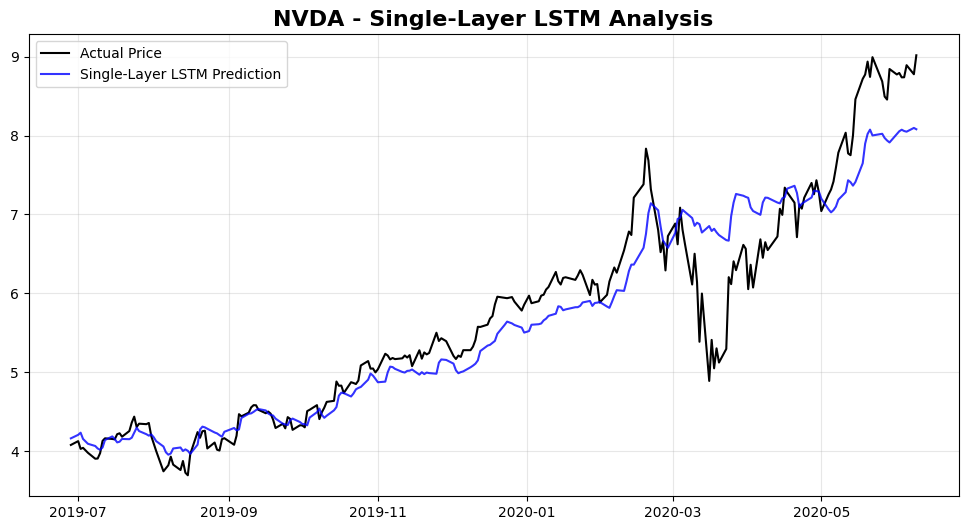

CPU times: user 454 ms, sys: 289 ms, total: 743 ms
Wall time: 983 ms


In [35]:
%%time
# --- Evaluation using the best model ---
print("\n--- Evaluating Best Single-Layer LSTM Model ---")
single_layer_lstm_preds = single_lstm_model.predict(X_test_tech, verbose=0)

# Re-create the scaler based on the training data's 'Close' price
close_scaler = MinMaxScaler()
close_scaler.fit(tech_data[["Close"]][: len(X_train_tech)])  # Fit only on the training part

# Inverse transforms the actual and predicted values
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(single_layer_lstm_preds)

# Calculate and print metrics
baseline_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_preds_scaled, "Single-Layer LSTM"
)
print(baseline_metrics)

# Plot the results
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Single-Layer LSTM",
)

### Multi Layer LSTM Models

In [11]:
%%time
print("\n--- Tuning Multi-Layer LSTM Model ---")

# Define the input shape from our training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner
tuner_multi_lstm = kt.Hyperband(
    # Pass the input_shape to the model-building function
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="multi_layer_lstm",  # New project name to store results separately
    overwrite=True,
)

# Define a callback to stop training early if val_loss isn't improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting hyperparameter search...")
tuner_multi_lstm.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_multi_lstm = tuner_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_layer_model = tuner_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: {best_hps_multi_lstm.get('units_1')}
Units Layer 2: {best_hps_multi_lstm.get('units_2')}
Dropout: {best_hps_multi_lstm.get('dropout'):.2f}
Learning Rate: {best_hps_multi_lstm.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 12s]
val_loss: 0.013488568365573883

Best val_loss So Far: 0.009709831327199936
Total elapsed time: 00h 27m 45s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer LSTM:
Units Layer 1: 128
Units Layer 2: 64
Dropout: 0.30
Learning Rate: 0.0001
---

CPU times: user 4min 12s, sys: 1min 26s, total: 5min 38s
Wall time: 27min 46s


\n--- Evaluating Best Multi-Layer LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


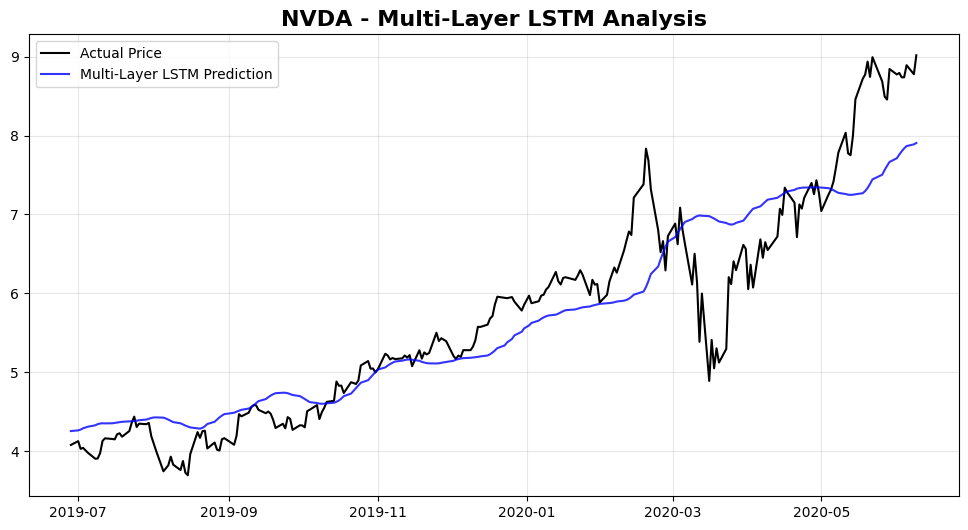

{'Model': 'Multi-Layer LSTM', 'RMSE': np.float64(0.5897055917234991), 'MAE': 0.4171165601977743, 'Directional_Accuracy': np.float64(53.36134453781513)}
CPU times: user 775 ms, sys: 292 ms, total: 1.07 s
Wall time: 1.17 s


In [36]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Multi-Layer LSTM Model ---")
multi_preds = multi_layer_model.predict(X_test_tech, verbose=0)

# We can reuse the same scaler fitted before
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)

multi_layer_metrics = ut.calculate_metrics(
    y_test_tech_scaled, multi_preds_scaled, "Multi-Layer LSTM"
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    multi_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Multi-Layer LSTM",
)

print(multi_layer_metrics)

### Single-Layer Enhanced LSTM Model

In [13]:
%%time
print("\n--- Tuning Single-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_single_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_single_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    # Use a new project name for the enhanced model
    project_name="enhanced_single_layer_lstm",
    overwrite=True,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_single_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_single = tuner_enh_single_lstm.get_best_hyperparameters(num_trials=1)[0]
enhanced_model = tuner_enh_single_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: {best_hps_enh_single.get('units')}
Dropout: {best_hps_enh_single.get('dropout'):.2f}
Learning Rate: {best_hps_enh_single.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 24s]
val_loss: 0.007391876075416803

Best val_loss So Far: 0.005545529071241617
Total elapsed time: 00h 04m 27s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced Single-Layer LSTM:
Units: 224
Dropout: 0.20
Learning Rate: 0.0001
---

CPU times: user 3min 22s, sys: 1min 21s, total: 4min 44s
Wall time: 4min 28s


\n--- Evaluating Best Enhanced Single-Layer LSTM Model ---
Plotting results for the best enhanced model...
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


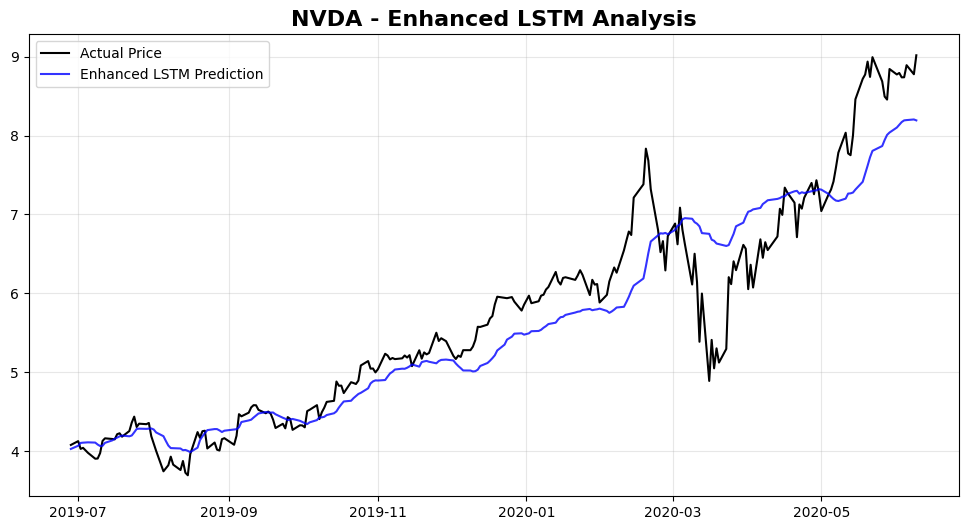

{'Model': 'Enhanced LSTM', 'RMSE': np.float64(0.50321919928759), 'MAE': 0.3614412221948472, 'Directional_Accuracy': np.float64(48.739495798319325)}
CPU times: user 470 ms, sys: 109 ms, total: 579 ms
Wall time: 636 ms


In [37]:
%%time
print("\n--- Evaluating Best Enhanced Single-Layer LSTM Model ---")
enh_preds = enhanced_model.predict(X_test_enh, verbose=0)

# IMPORTANT: Use the scaler that was fitted to the enhanced data
close_scaler_enh = MinMaxScaler().fit(enhanced_full_data[["Close"]][: len(X_train_enh)])

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler_enh.inverse_transform(enh_preds)

enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_preds_scaled, "Enhanced LSTM"
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best enhanced model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced LSTM",
)

print(enhanced_metrics)

### Multi-Layer Enhanced LSTM Model

In [15]:
%%time
print("\n--- Tuning Multi-Layer Enhanced LSTM Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner
tuner_enh_multi_lstm = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_multi_layer_lstm(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    # Use a new project name for this specific model
    project_name="enhanced_multi_layer_lstm",
    overwrite=True,
)

# Define a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the ENHANCED data
print("Starting hyperparameter search on enhanced data...")
tuner_enh_multi_lstm.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_multi = tuner_enh_multi_lstm.get_best_hyperparameters(num_trials=1)[0]
multi_enhanced_model = tuner_enh_multi_lstm.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: {best_hps_enh_multi.get('units_1')}
Units Layer 2: {best_hps_enh_multi.get('units_2')}
Dropout: {best_hps_enh_multi.get('dropout'):.2f}
Learning Rate: {best_hps_enh_multi.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 31s]
val_loss: 0.006586795672774315

Best val_loss So Far: 0.0064167361706495285
Total elapsed time: 00h 07m 08s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Multi-Layer Enhanced LSTM:
Units Layer 1: 192
Units Layer 2: 96
Dropout: 0.20
Learning Rate: 0.0001
---

CPU times: user 5min 45s, sys: 2min 3s, total: 7min 48s
Wall time: 7min 9s


\n--- Evaluating Best Multi-Layer Enhanced LSTM Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


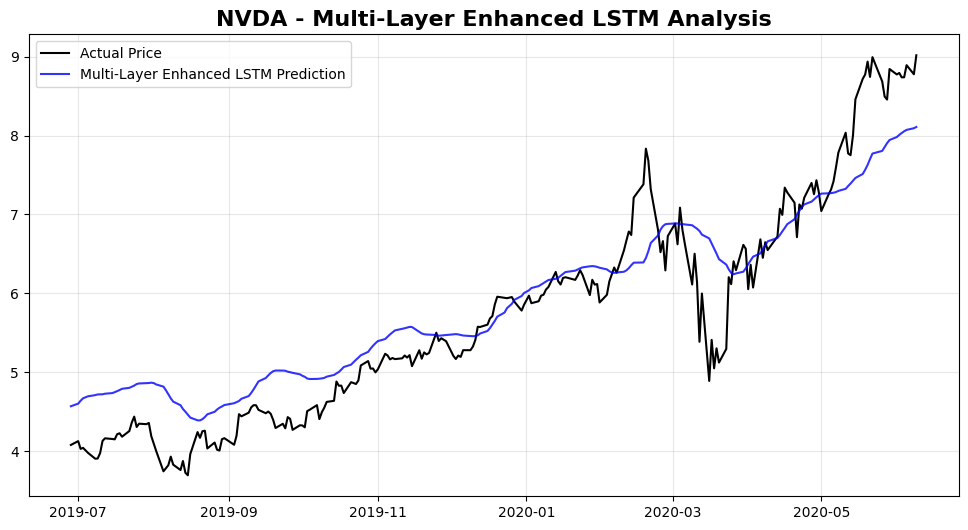

{'Model': 'Multi-Layer Enhanced LSTM', 'RMSE': np.float64(0.5319614735060371), 'MAE': 0.4162752917620926, 'Directional_Accuracy': np.float64(55.04201680672269)}
CPU times: user 765 ms, sys: 291 ms, total: 1.06 s
Wall time: 1.15 s


In [38]:
%%time
# Proceed with evaluation using the best ENHANCED model
print("\n--- Evaluating Best Multi-Layer Enhanced LSTM Model ---")
multi_enh_preds = multi_enhanced_model.predict(X_test_enh, verbose=0)

# We can reuse the same scaler fitted for the enhanced data
y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
multi_enh_preds_scaled = close_scaler_enh.inverse_transform(multi_enh_preds)

multi_enhanced_metrics = ut.calculate_metrics(
    y_test_enh_scaled, multi_enh_preds_scaled, "Multi-Layer Enhanced LSTM"
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    multi_enh_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Multi-Layer Enhanced LSTM",
)

print(multi_enhanced_metrics)

### Support Vector Machine (SVM) Models

In [17]:
%%time
print("\n--- Preparing Data and Tuning SVM Model ---")
# SVM requires 2D input, so we flatten the sequence data
nsamples, nx, ny = X_train_tech.shape
X_train_svm_tech = X_train_tech.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_tech.shape
X_test_svm_tech = X_test_tech.reshape((nsamples, nx * ny))

print(f"Reshaped baseline data for SVM: {X_train_svm_tech.shape}")

\n--- Preparing Data and Tuning SVM Model ---
Reshaped baseline data for SVM: (2118, 300)
CPU times: user 288 µs, sys: 268 µs, total: 556 µs
Wall time: 356 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packag

[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsil

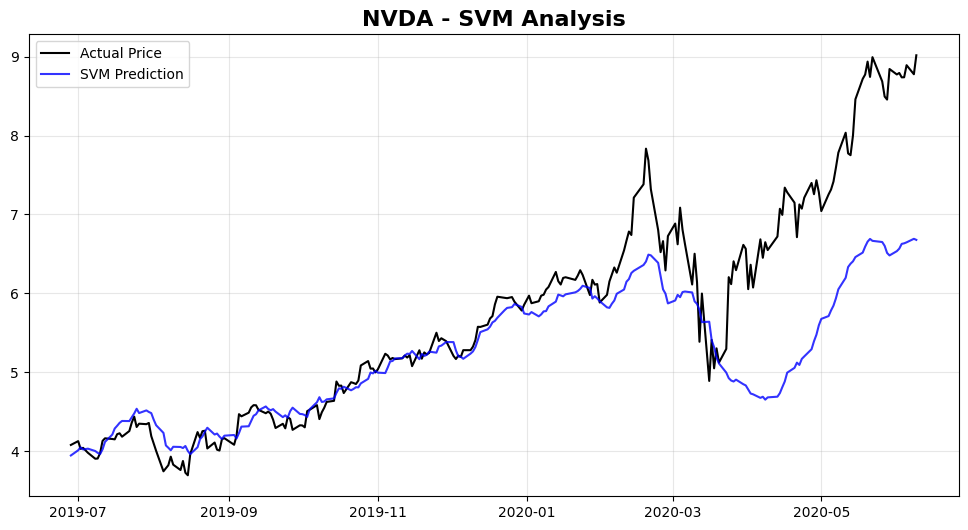

{'Model': 'SVM', 'RMSE': np.float64(0.9478845214128906), 'MAE': 0.5824462107741665, 'Directional_Accuracy': np.float64(45.79831932773109)}
CPU times: user 193 ms, sys: 325 ms, total: 518 ms
Wall time: 2.39 s


In [39]:
%%time
# Build and train the SVM by running the grid search
baseline_svm_model = mdl.build_and_train_svm(X_train_svm_tech, y_train_tech)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best SVM Model ---")
base_svm_preds = baseline_svm_model.predict(X_test_svm_tech)

base_svm_preds_scaled = close_scaler.inverse_transform(base_svm_preds.reshape(-1, 1))
baseline_svm_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_svm_preds_scaled, "SVM"
)

# Plot the results
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_svm_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "SVM",
)

print(baseline_svm_metrics)

### Enhanced Support Vector Machine (SVM) Models

In [19]:
%%time
print("\n--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---")
# Reshape the enhanced data for SVM's 2D input requirement
nsamples, nx, ny = X_train_enh.shape
X_train_svm_enh = X_train_enh.reshape((nsamples, nx * ny))

nsamples, nx, ny = X_test_enh.shape
X_test_svm_enh = X_test_enh.reshape((nsamples, nx * ny))

print(f"Reshaped enhanced data for SVM: {X_train_svm_enh.shape}")

\n--- Preparing Enhanced Data and Tuning Enhanced SVM Model ---
Reshaped enhanced data for SVM: (2118, 390)
CPU times: user 137 µs, sys: 505 µs, total: 642 µs
Wall time: 412 µs


Building and tuning SVM model with GridSearchCV...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ..........C=1, epsilon=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=1, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/sklearn/utils/parallel.py:135: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packag

[CV] END ........C=100, epsilon=0.05, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .......C=100, epsilon=0.05, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=100, epsilon=0.05, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   0.0s
Best SVM parameters found: {'C': 1, 'epsilon': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}
SVM tuning complete.
\n--- Evaluating Best Enhanced SVM Model ---
Plot saved to Output/NVDA_Enhanced_SVM_analysis.png


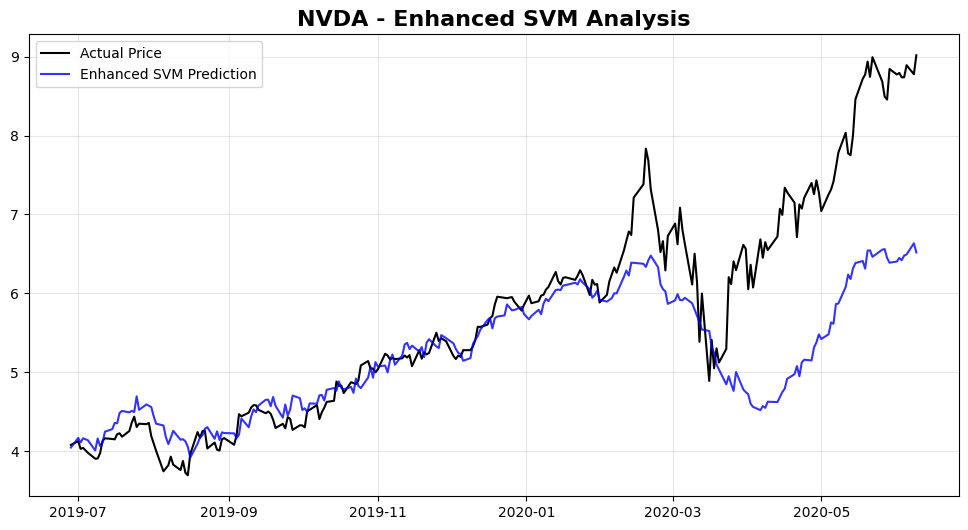

{'Model': 'Enhanced SVM', 'RMSE': np.float64(1.0015943481874598), 'MAE': 0.6213208271327761, 'Directional_Accuracy': np.float64(47.47899159663865)}
CPU times: user 170 ms, sys: 23.8 ms, total: 194 ms
Wall time: 476 ms


In [40]:
%%time
# Build and train the enhanced SVM by running the grid search
enhanced_svm_model = mdl.build_and_train_svm(X_train_svm_enh, y_train_enh)

# Evaluate the best model found by the tuner
print("\n--- Evaluating Best Enhanced SVM Model ---")
enh_svm_preds = enhanced_svm_model.predict(X_test_svm_enh)

# Use the scaler fitted on the enhanced data to inverse the transformation
enh_svm_preds_scaled = close_scaler_enh.inverse_transform(enh_svm_preds.reshape(-1, 1))
enhanced_svm_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_svm_preds_scaled, "Enhanced SVM"
)

# Plot the results
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_svm_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced SVM",
)

print(enhanced_svm_metrics)

### GRU Model

In [21]:
%%time
print("\n--- Tuning Baseline GRU Model ---")

# Define the input shape from our baseline training data
input_shape = (X_train_tech.shape[1], X_train_tech.shape[2])

# Instantiate the tuner for the GRU model
tuner_base_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="baseline_gru",
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search
print("Starting GRU hyperparameter search...")
tuner_base_gru.search(
    X_train_tech,
    y_train_tech,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_base_gru = tuner_base_gru.get_best_hyperparameters(num_trials=1)[0]
baseline_gru_model = tuner_base_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: {best_hps_base_gru.get('units_1')}
Units Layer 2: {best_hps_base_gru.get('units_2')}
Dropout: {best_hps_base_gru.get('dropout'):.2f}
Learning Rate: {best_hps_base_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 19s]
val_loss: 0.007340306881815195

Best val_loss So Far: 0.0041463542729616165
Total elapsed time: 00h 06m 53s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Baseline GRU:
Units Layer 1: 192
Units Layer 2: 128
Dropout: 0.10
Learning Rate: 0.001
---

CPU times: user 5min 50s, sys: 2min 2s, total: 7min 53s
Wall time: 6min 55s


\n--- Evaluating Best Baseline GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Baseline_GRU_analysis.png


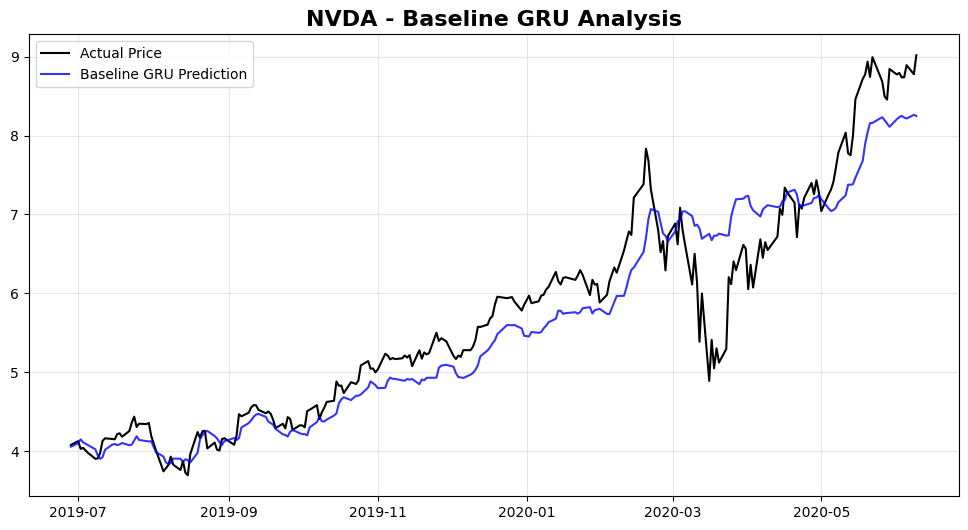

{'Model': 'Baseline GRU', 'RMSE': np.float64(0.4712581135221854), 'MAE': 0.3509796264281333, 'Directional_Accuracy': np.float64(44.537815126050425)}
CPU times: user 696 ms, sys: 299 ms, total: 995 ms
Wall time: 1.14 s


In [41]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Baseline GRU Model ---")
base_gru_preds = baseline_gru_model.predict(X_test_tech, verbose=0)

y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_gru_preds_scaled = close_scaler.inverse_transform(base_gru_preds)

baseline_gru_metrics = ut.calculate_metrics(
    y_test_tech_scaled, base_gru_preds_scaled, "Baseline GRU"
)
test_dates_tech = tech_data.index[-len(y_test_tech_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_tech_scaled,
    base_gru_preds_scaled,
    test_dates_tech,
    cfg.STOCK_SYMBOL,
    "Baseline GRU",
)

print(baseline_gru_metrics)

### Enhanced GRU Model

In [23]:
%%time
print("\n--- Tuning Enhanced GRU Model ---")

# Define the input shape from our ENHANCED training data
input_shape = (X_train_enh.shape[1], X_train_enh.shape[2])

# Instantiate the tuner for the Enhanced GRU model
tuner_enh_gru = kt.Hyperband(
    hypermodel=lambda hp: mdl.build_gru(hp, input_shape=input_shape),
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="enhanced_gru",  # New project name
    overwrite=True,
)

# Define a callback to stop training early
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Run the hyperparameter search on the enhanced data
print("Starting Enhanced GRU hyperparameter search...")
tuner_enh_gru.search(
    X_train_enh,
    y_train_enh,
    epochs=50,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=2,
)
print("\\nHyperparameter search complete.")

# Get the optimal hyperparameters and the best model
best_hps_enh_gru = tuner_enh_gru.get_best_hyperparameters(num_trials=1)[0]
enhanced_gru_model = tuner_enh_gru.get_best_models(num_models=1)[0]

print(
    f"""
---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: {best_hps_enh_gru.get('units_1')}
Units Layer 2: {best_hps_enh_gru.get('units_2')}
Dropout: {best_hps_enh_gru.get('dropout'):.2f}
Learning Rate: {best_hps_enh_gru.get('learning_rate')}
---
"""
)

Trial 30 Complete [00h 00m 14s]
val_loss: 0.014198568649590015

Best val_loss So Far: 0.003679328365251422
Total elapsed time: 00h 07m 00s
\nHyperparameter search complete.

---
Optimal Hyperparameters for Enhanced GRU:
Units Layer 1: 128
Units Layer 2: 96
Dropout: 0.10
Learning Rate: 0.0001
---

CPU times: user 5min 54s, sys: 2min, total: 7min 54s
Wall time: 7min 1s


\n--- Evaluating Best Enhanced GRU Model ---
Plotting results for the best model...
Plot saved to Output/NVDA_Enhanced_GRU_analysis.png


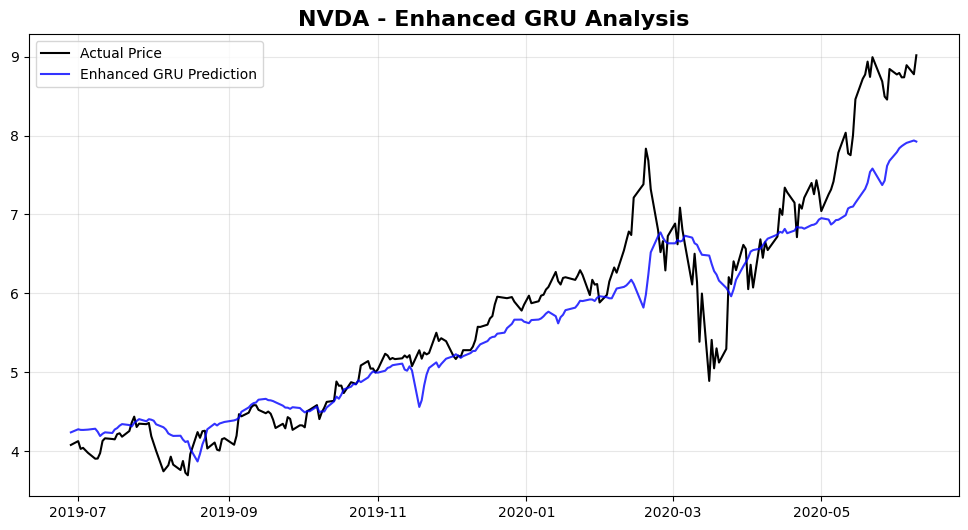

{'Model': 'Enhanced GRU', 'RMSE': np.float64(0.505212064895671), 'MAE': 0.35431164079131444, 'Directional_Accuracy': np.float64(52.94117647058824)}
CPU times: user 198 ms, sys: 43.4 ms, total: 241 ms
Wall time: 255 ms


In [42]:
%%time
# Proceed with evaluation using the best model
print("\n--- Evaluating Best Enhanced GRU Model ---")
enh_gru_preds = enhanced_gru_model.predict(X_test_enh, verbose=0)

y_test_enh_scaled = close_scaler_enh.inverse_transform(y_test_enh.reshape(-1, 1))
enh_gru_preds_scaled = close_scaler_enh.inverse_transform(enh_gru_preds)

enhanced_gru_metrics = ut.calculate_metrics(
    y_test_enh_scaled, enh_gru_preds_scaled, "Enhanced GRU"
)
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled) :]

# Plot the results
print("Plotting results for the best model...")
ut.plot_non_keras_results(
    y_test_enh_scaled,
    enh_gru_preds_scaled,
    test_dates_enh,
    cfg.STOCK_SYMBOL,
    "Enhanced GRU",
)

print(enhanced_gru_metrics)

### ARIMA Model

\n--- Finding Best ARIMA Order ---
Searching for the best ARIMA order...
Best ARIMA order found: (4, 1, 2) with AIC: -5260.84


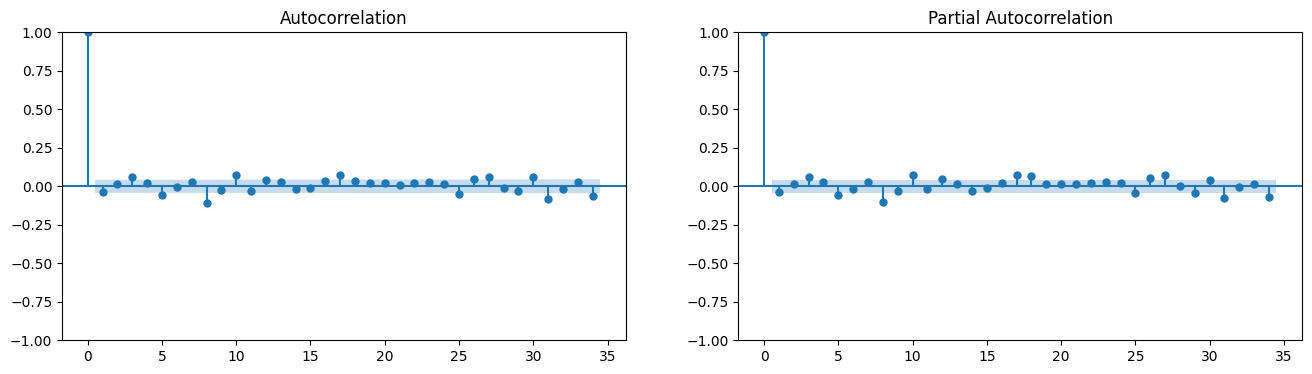

CPU times: user 13.4 s, sys: 113 ms, total: 13.5 s
Wall time: 13.6 s


In [25]:
%%time
print("\n--- Finding Best ARIMA Order ---")
# ARIMA works on the unscaled, 1D time series of the target variable
close_prices = tech_data[cfg.BASELINE_TARGET]
train_size = int(len(close_prices) * (1 - cfg.TEST_SIZE))
train_arima, test_arima = close_prices[0:train_size], close_prices[train_size:]

# Find the best order using our new function
best_arima_order = mdl.find_best_arima_order(train_arima)

# Plot ACF and PACF for visual inspection
# This helps to manually verify the p and q values.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train_arima.diff().dropna(), ax=axes[0])
plot_pacf(train_arima.diff().dropna(), ax=axes[1], method="ywm")
plt.show()

In [26]:
%%time
print(f"\n--- Running ARIMA Model with best order {best_arima_order} ---")

history = [x for x in train_arima]
arima_predictions = []

print(f"Performing rolling forecast for {len(test_arima)} steps...")
# The tqdm library provides a progress bar, which is useful here

for t in tqdm(range(len(test_arima))):
    # Use the best order found previously for every forecast
    model_arima = mdl.build_and_train_arima(history, order=best_arima_order)
    output = model_arima.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_arima[t]
    history.append(obs)

print("ARIMA forecast complete.")

\n--- Running ARIMA Model with best order (4, 1, 2) ---
Performing rolling forecast for 239 steps...


  0%|          | 0/239 [00:00<?, ?it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 17%|█▋        | 40/239 [00:30<02:36,  1.27it/s]/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

ARIMA forecast complete.
CPU times: user 3min 14s, sys: 1.38 s, total: 3min 16s
Wall time: 3min 16s


Plot saved to Output/NVDA_ARIMA_analysis.png


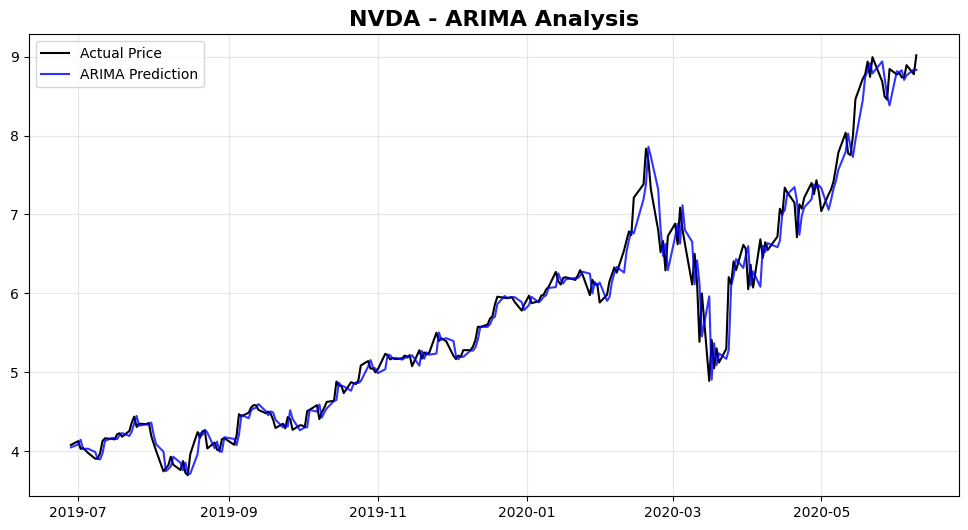

{'Model': 'ARIMA', 'RMSE': np.float64(0.20708592426522224), 'MAE': 0.1393373133497383, 'Directional_Accuracy': np.float64(41.596638655462186)}
CPU times: user 104 ms, sys: 5.18 ms, total: 109 ms
Wall time: 110 ms


In [43]:
%%time
arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)
y_test_arima_np = np.array(test_arima).reshape(-1, 1)
arima_metrics = ut.calculate_metrics(
    y_test_arima_np, arima_predictions_np, "ARIMA"
)

ut.plot_non_keras_results(
    y_test_arima_np,
    arima_predictions_np,
    test_arima.index,
    cfg.STOCK_SYMBOL,
    "ARIMA",
)

print(arima_metrics)

### 7. Final Performance Comparison

In [28]:
%%time
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, "Naive Baseline")

# --- UPDATED TO INCLUDE ALL MODELS ---
all_metrics_df = pd.DataFrame(
    [
        naive_metrics,
        baseline_metrics,
        enhanced_metrics,
        multi_layer_metrics,
        multi_enhanced_metrics,
        baseline_gru_metrics,
        enhanced_gru_metrics,
        baseline_svm_metrics,
        enhanced_svm_metrics,
        arima_metrics,
    ]
).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))
print("-" * 60)

metrics_to_evaluate = {"RMSE": "min", "MAE": "min", "Directional_Accuracy": "max"}

print("\n🏆 Best Model for Each Metric")
print("-" * 30)
for metric, method in metrics_to_evaluate.items():
    if method == "min":
        winner_idx = all_metrics_df[metric].idxmin()
    else:
        winner_idx = all_metrics_df[metric].idxmax()
    winner_row = all_metrics_df.loc[winner_idx]
    print(f"{metric:<22}: {winner_row['Model']} (Score: {winner_row[metric]:.4f})")


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                          Model   RMSE    MAE  Directional_Accuracy
                 Naive Baseline 0.2105 0.1422               39.9160
              Single-Layer LSTM 0.4727 0.3315               47.0588
                  Enhanced LSTM 0.5032 0.3614               48.7395
               Multi-Layer LSTM 0.5897 0.4171               53.3613
Tuned Multi-Layer Enhanced LSTM 0.5320 0.4163               55.0420
             Tuned Baseline GRU 0.4713 0.3510               44.5378
             Tuned Enhanced GRU 0.5052 0.3543               52.9412
                      Tuned SVM 0.9479 0.5824               45.7983
             Tuned Enhanced SVM 1.0016 0.6213               47.4790
                    Tuned ARIMA 0.2071 0.1393               41.5966
------------------------------------------------------------

🏆 Best Model for Each Metric
------------------------------
RMSE                  : Tuned

In [44]:
%%time
ranking_df = all_metrics_df.copy()

ranking_df["RMSE_Rank"] = ranking_df["RMSE"].rank(method="min", ascending=True)
ranking_df["MAE_Rank"] = ranking_df["MAE"].rank(method="min", ascending=True)


ranking_df["DA_Rank"] = ranking_df["Directional_Accuracy"].rank(
    method="min", ascending=False
)

ranking_df["Total_Rank"] = (
    ranking_df["RMSE_Rank"] + ranking_df["MAE_Rank"] + ranking_df["DA_Rank"]
)

final_ranking = ranking_df.sort_values(by="Total_Rank", ascending=True)

print("-" * 40)
print("\n🏆 Overall Model Ranking (Best to Worst)")
print("-" * 40)
print(
    final_ranking[["Model", "Total_Rank", "RMSE", "Directional_Accuracy"]]
    .reset_index(drop=True)
    .to_string()
)

----------------------------------------
\n🏆 Overall Model Ranking (Best to Worst)
----------------------------------------
                             Model  Total_Rank    RMSE  Directional_Accuracy
0                      Tuned ARIMA        11.0  0.2071               41.5966
1                Single-Layer LSTM        13.0  0.4727               47.0588
2                   Naive Baseline        14.0  0.2105               39.9160
3               Tuned Enhanced GRU        14.0  0.5052               52.9412
4                    Enhanced LSTM        15.0  0.5032               48.7395
5  Tuned Multi-Layer Enhanced LSTM        15.0  0.5320               55.0420
6               Tuned Baseline GRU        15.0  0.4713               44.5378
7                 Multi-Layer LSTM        18.0  0.5897               53.3613
8                        Tuned SVM        25.0  0.9479               45.7983
9               Tuned Enhanced SVM        25.0  1.0016               47.4790
CPU times: user 2.75 ms, sys:

Plot saved to Output/NVDA_all_models_comparison.png


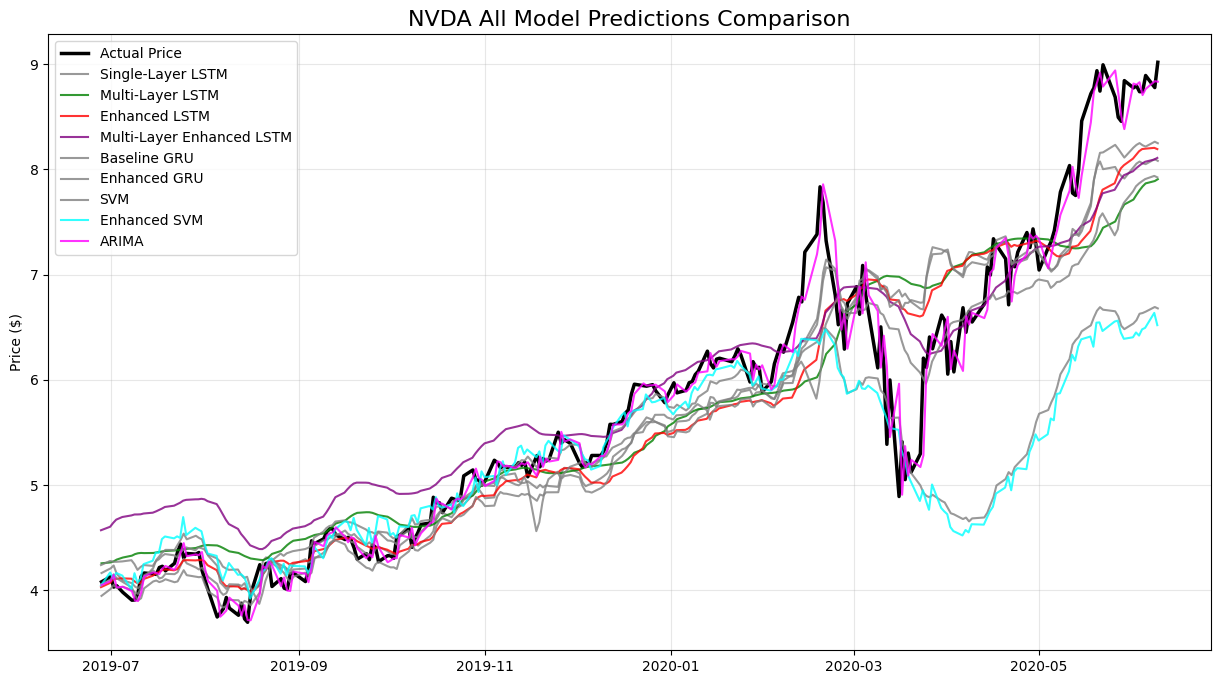

CPU times: user 164 ms, sys: 9.32 ms, total: 173 ms
Wall time: 173 ms


In [31]:
%%time
plot_data = {
    "Actual": {"dates": test_dates_tech, "values": y_test_tech_scaled},
    "Single-Layer LSTM": {"dates": test_dates_tech, "values": base_preds_scaled},
    "Multi-Layer LSTM": {"dates": test_dates_tech, "values": multi_preds_scaled},
    "Enhanced LSTM": {"dates": test_dates_enh, "values": enh_preds_scaled},
    "Multi-Layer Enhanced LSTM": {
        "dates": test_dates_enh,
        "values": multi_enh_preds_scaled,
    },
    "Baseline GRU": {"dates": test_dates_tech, "values": base_gru_preds_scaled},
    "Enhanced GRU": {"dates": test_dates_enh, "values": enh_gru_preds_scaled},
    "SVM": {"dates": test_dates_tech, "values": base_svm_preds_scaled},
    "Enhanced SVM": {"dates": test_dates_enh, "values": enh_svm_preds_scaled},
    "ARIMA": {"dates": test_arima.index, "values": arima_predictions_np},
}

ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL)

In [32]:
try:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Total Notebook Runtime: {total_time:.2f} seconds ---")
except NameError:
    print("⚠️ --- Timer could not be stopped because 'start_time' was not defined.")

--- Total Notebook Runtime: 3659.46 seconds ---
